# Here the TFacTomo algorithm is used step by step with comments regarding the math, such that it is really understandable

Here is the Github suggestion how to run TFacTomo (this is exactly how it is written):

Python packages to be run:

[python 3.8.12]
[numpy 1.21.5]
[pytorch 1.10.2]
[tensorly 0.6.0]

R packages to be run

[R 4.2.2]
[shiny 1.7.1]
[reticulate 1.25]


-----------------------------------------------------------------------------------------------------------------------------------------------------------------

Reproducing Results on Mouse Olfactory Mucosa

Reconstruction

You can skip this step if you just want to use the tensor models already in our repository.

They are stored in vis_OM/tensor_model/*.npy

-----------------------------------------------------------------------------------------------------------------------------------------------------------------


1) Run the tensor model on 1D spatial gene expression data (tomo-seq), protein-protein interaction (PPI) network and spatial chain graphs, and 3D binary mask (where 0s indicate no tissue covered).


--> Load required packages:


import torch
import numpy as np
import tensorly as tl
from TFacTomo import reconstruct


--> Set tensorly backend as pytorch
tl.set_backend('pytorch')




!! Load 1D gene expression data along different spatial axes !!

X_x = np.load("data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy"); X_x = torch.from_numpy(X_x).to(torch.float)
X_y = np.load("data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy"); X_y = torch.from_numpy(X_y).to(torch.float)
X_z = np.load("data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy"); X_z = torch.from_numpy(X_z).to(torch.float)

!! Load knowledge graphs along gene and spatial axes !!

W_g = np.load("data/mouse_olfactory_mucosa/mus_musculus_ppi_adjacency_matrix.npy"); W_g = torch.from_numpy(W_g).to(torch.float)
W_x = np.load("data/mouse_olfactory_mucosa/W_x.npy"); W_x = torch.from_numpy(W_x).to(torch.float)
W_y = np.load("data/mouse_olfactory_mucosa/W_y.npy"); W_y = torch.from_numpy(W_y).to(torch.float)
W_z = np.load("data/mouse_olfactory_mucosa/W_z.npy"); W_z = torch.from_numpy(W_z).to(torch.float)

!! Load the 3D binary mask !!

M = np.load("data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------



-->  Reconstruct 4D expression tensor by setting hyperparameters rank=500, alpha=1e2, beta=1, and lambda=1, where lambda is a
--> hyperparameter controlling l2 regularization on tensor factors, we kept using 1 in our experiments reported in the paper.

This is how you run the code:


A = reconstruct([X_x, X_y, X_z], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=1000)

save the following way:

T_hat = tl.cp_tensor.cp_to_tensor((None, A))
torch.save(A, "results/mouse_olfactory_mucosa_CPD_factors.pt")

-----------------------------------------------------------------------------------------------------------------------------------------------------------------

2) Save CANDECOMP/PARAFAC (CP) decomposition factors (A_g, A_x, A_y, A_z) for visualization.

A = torch.load("results/mouse_olfactory_mucosa_CPD_factors.pt")
np.save("A_g.npy", A[0])
np.save("A_x.npy", A[1])
np.save("A_y.npy", A[2])
np.save("A_z.npy", A[3])

-----------------------------------------------------------------------------------------------------------------------------------------------------------------


3) Visualization (This part does not work --> I need help here)

--> Load required packages
library(shiny)
library(reticulate)
source("vis_OM/server.R")
source("vis_OM/ui.R")

--> Load in environment variables using OM_TFacTomo.RData
load("vis_OM/OM_TFacTomo.RData")

--> Load in the gene symbols and CP factors (A_g, A_x, A_y, A_z)
np <- import("numpy") # using the reticulate package to load Python objects into R
genes <- np$loadtxt("genes.txt") 
A_g <- np$load("vis_OM/tensor_model/A_g.npy")
A_x <- np$load("vis_OM/tensor_model/A_x.npy")
A_y <- np$load("vis_OM/tensor_model/A_y.npy")
A_z <- np$load("vis_OM/tensor_model/A_z.npy")

--> Launch R shiny App to see the 3D expression reconstruction interactively (Under construction ...)
shinyApp(ui, server)

# TFacTomo using the data from the TFacTomo authors

loading needed packages

In [2]:
import os
import gc
import torch
import numpy as np
import tensorly as tl
from functools import reduce
from tensorly.cp_tensor import cp_to_tensor

# you need to be in the CTFacTomo folder such that you can run the TFacTomo package

import sys
sys.path.append('/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo')  
from TFacTomo import reconstruct # this is the function


loading the data

In [4]:
# Load 1D gene expression data along different spatial axes 
X_x_lml = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy"); X_x_lml = torch.from_numpy(X_x_lml).to(torch.float)
X_y_dv = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy"); X_y_dv = torch.from_numpy(X_y_dv).to(torch.float)
X_z_ap = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy"); X_z_ap = torch.from_numpy(X_z_ap).to(torch.float)

genes = np.loadtxt("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/genes.txt", dtype=str)
# Load knowledge graphs along gene and spatial axes
W_g = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mus_musculus_ppi_adjacency_matrix.npy"); W_g = torch.from_numpy(W_g).to(torch.float)
W_x = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_x.npy"); W_x = torch.from_numpy(W_x).to(torch.float)
W_y = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_y.npy"); W_y = torch.from_numpy(W_y).to(torch.float)
W_z = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_z.npy"); W_z = torch.from_numpy(W_z).to(torch.float)


# Load the 3D binary mask 
M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


using the reconstruct function (this is the mai function of TFacTomo, reconstructing the tensor as a decomposed version of 4 factor matrices)

In [ ]:
A = reconstruct([X_y_dv, X_x_lml, X_z_ap], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)
T_hat = tl.cp_tensor.cp_to_tensor((None, A))




Training epoch: 10, Residual: 0.0350
Training epoch: 20, Residual: 0.0194
Training epoch: 30, Residual: 0.0131
Training epoch: 40, Residual: 0.0108
Training epoch: 50, Residual: 0.0085
Training epoch: 60, Residual: 0.0067
Training epoch: 70, Residual: 0.0056
Training epoch: 80, Residual: 0.0047
Training epoch: 90, Residual: 0.0041
Training epoch: 100, Residual: 0.0036
Training epoch: 110, Residual: 0.0033
Training epoch: 120, Residual: 0.0031
Training epoch: 130, Residual: 0.0029
Training epoch: 140, Residual: 0.0027
Training epoch: 150, Residual: 0.0026
Training epoch: 160, Residual: 0.0026
Training epoch: 170, Residual: 0.0025
Training epoch: 180, Residual: 0.0025
Training epoch: 190, Residual: 0.0023
Training epoch: 200, Residual: 0.0022
Training epoch: 210, Residual: 0.0020
Training epoch: 220, Residual: 0.0018
Training epoch: 230, Residual: 0.0017
Training epoch: 240, Residual: 0.0016
Training epoch: 250, Residual: 0.0015
Training epoch: 260, Residual: 0.0014
Training epoch: 270, 

Saving the factor matrices

In [6]:
torch.save(A, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/tfactomo_factor_matrix.pt")

Visualizing the results

In [5]:
from tensorly.cp_tensor import cp_to_tensor

tl.set_backend('numpy')

A = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/tfactomo_factor_matrix.pt")


# normalize by total expression

factors = [a.cpu().numpy() for a in A] # factors of the tensor --> 
full4d  = cp_to_tensor((None, factors))   # shape (n_genes, n_y, n_x, n_z)


# select one specific gene, here Moxd2 for visualization

gene_name = "Moxd2"

g_idx    = np.where(genes==gene_name)[0][0]

mask3d = M.cpu().numpy() 

vol3d = full4d[g_idx]     # shape (n_y, n_x, n_z)

#proj_tfactomo = np.log10(vol3d + 1)

proj_tfactomo = vol3d

proj_tfactomo *= mask3d



Saving the tensor from TFacTomo using Mayras data for 503 genes

In [6]:
# creating a function to visualize different slices:


def visualize_pa_slice_old(T, slice_idx, gene):

    # importing needed packages 
    
    from matplotlib.colors import ListedColormap
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt
    import seaborn as sns

    T = np.log10(T + 1)

    r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["silver", "blue", "yellow", "orange", "red"], N=100)
    white_cmap = ListedColormap(["white"])

          
    pa_slice     = T[:, :, slice_idx]
    mask_slice   = mask3d[:,:, slice_idx]
    mask_overlay = np.where(mask_slice==0, 1, np.nan)

    plt.figure(figsize=(8,5.5))
    sns.heatmap(pa_slice, cmap=r_palette, vmin=T.min(), vmax=0.3)
    #plt.gca().invert_yaxis()
    sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
    plt.title(f"Gene {gene} at AP slice = {slice_idx}", fontsize=20)
    plt.xlabel("LML axis", fontsize=20)
    plt.ylabel("DV axis", fontsize=20)
    plt.show()




In [7]:
def r_style_limits_from_ipf(V_ipf, mask, drop_zeros=True):
    A = np.log1p(V_ipf)       # same transform as R: log10(·)+1 vs log1p — choose one and stick to it
    Ms = (mask > 0)
    if drop_zeros:
        Ms = Ms & (V_ipf > 0)
    vals = A[Ms]
    if vals.size == 0:
        return 0.0, 1.0
    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax: vmax = vmin + 1e-12
    return vmin, vmax

vmin, vmax = r_style_limits_from_ipf(ipf_moxd2, mask3d, drop_zeros=True)

NameError: name 'ipf_moxd2' is not defined

In [8]:
def scale_total(Yhat, Yref, M):
    num = float((Yref * M).sum())
    den = float((Yhat * M).sum())
    a = 0.0 if den == 0.0 else num / den
    return Yhat * a, a

M_bool = (mask3d > 0)
V_tfact_scaled, a = scale_total(proj_tfactomo, ipf_moxd2, M_bool)

# plotting slices with the *same* vmin/vmax
def visualize_pa_slice(T, mask, slice_idx, gene, vmin, vmax, use_log10=True):
    import seaborn as sns, matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    Tplot = np.log10(T + 1) if use_log10 else T
    r_palette = LinearSegmentedColormap.from_list(
        "R_palette", ["silver","blue","yellow","orange","red"], N=100)
    white_cmap = ListedColormap(["white"])

    pa_slice   = Tplot[:, :, slice_idx]
    mask_slice = mask[:, :, slice_idx] > 0
    mask_overlay = np.where(mask_slice, np.nan, 1.0)

    plt.figure(figsize=(8,5.5))
    sns.heatmap(pa_slice, cmap=r_palette, vmin=vmin, vmax=vmax)
    sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
    plt.title(f"{gene} | AP slice {slice_idx}")
    plt.xlabel("LML"); plt.ylabel("DV")
    plt.show()



NameError: name 'ipf_moxd2' is not defined

In [ ]:
gene = 'Nqo1'
# Example: plot IPF and TFacto with IPF-derived limits


NameError: name 'visualize_pa_slice' is not defined

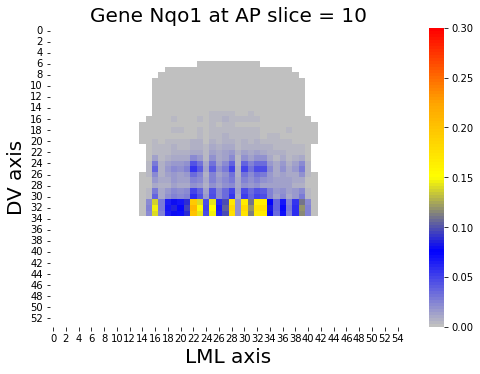

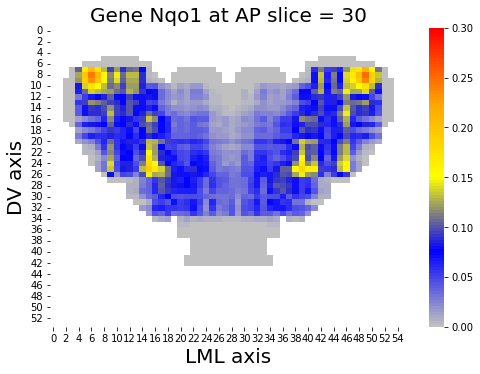

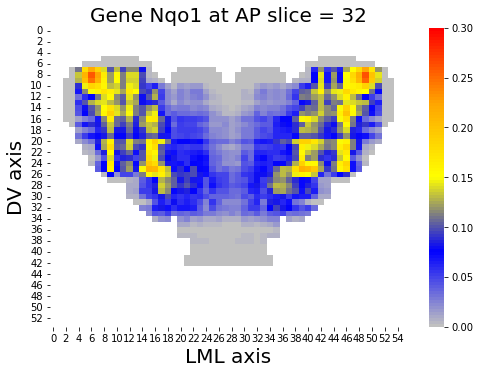

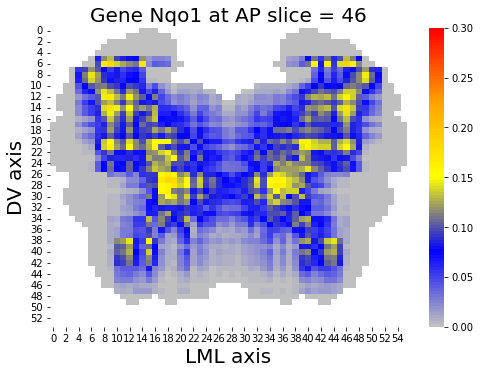

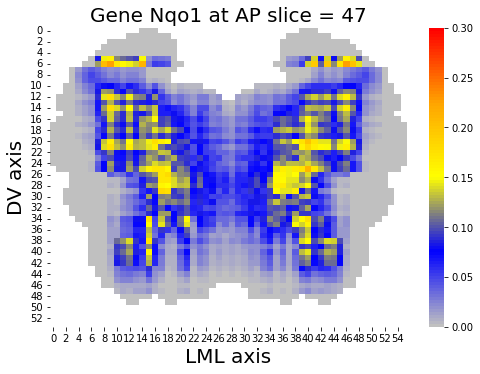

test


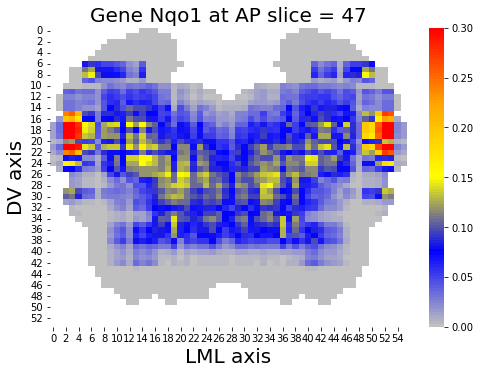

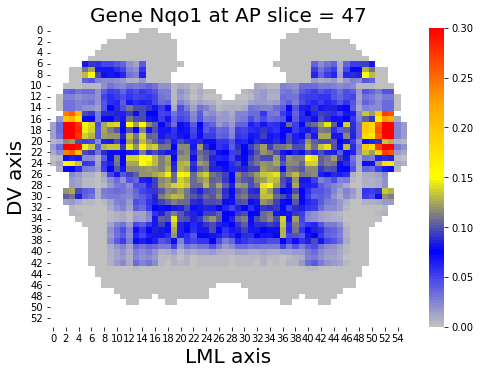

In [148]:
# visualize different slices of the A-P-axis.

gene = 'Nqo1'
visualize_pa_slice_old(T=proj_tfactomo, slice_idx=10, gene=f'{gene}')
visualize_pa_slice_old(T=proj_tfactomo, slice_idx=30, gene=f'{gene}')
visualize_pa_slice_old(T=proj_tfactomo, slice_idx=32, gene=f'{gene}')
visualize_pa_slice_old(T=proj_tfactomo, slice_idx=46, gene=f'{gene}')
visualize_pa_slice_old(T=proj_tfactomo, slice_idx=47, gene=f'{gene}')

print('test')
visualize_pa_slice_old(T=T_mayra_moxd2, slice_idx=47, gene=f'{gene}')
visualize_pa_slice_old(T=T_tfactomo_test[501], slice_idx=47, gene=f'{gene}')


# Mayras data processing and using TFacTOMO

In [38]:
import pandas as pd

# these dataframes have the gene names
DV_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/DV_RPMnormExpression1D.csv', index_col=0) # 54 cols # 17628 rows × 54 columns
PA_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/AP_RPMnormExpression1D.csv', index_col=0) # 60 cols
LML_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/LML_RPMnormExpression1D.csv', index_col=0) # 56 cols

# fitted dataframes have no index yet --> need to insert gene index
DV_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedDV.csv') # 17628 rows × 54 columns
PA_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedAP.csv') 
LML_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedLML.csv')

# loading volume of the slices along each axis
volume_PA = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolAP.csv')
volume_DV = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolDV.csv')
volume_LML = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolLML.csv')


# need to insert gene name column
DV_axis_fitted.insert(0, 'gene_name', DV_axis_norm.index.to_list())
PA_axis_fitted.insert(0, 'gene_name', PA_axis_norm.index.to_list())
LML_axis_fitted.insert(0, 'gene_name', LML_axis_norm.index.to_list())

# rename gene column properly
DV_axis_fitted = DV_axis_fitted.set_index('gene_name')
PA_axis_fitted = PA_axis_fitted.set_index('gene_name')
LML_axis_fitted = LML_axis_fitted.set_index('gene_name')


volume_DV = volume_DV.iloc[:, 0]
volume_PA = volume_PA.iloc[:, 0]
volume_LML = volume_LML.iloc[:, 0]


#select common genes from TFacTomo authors data and mouse olfactory mucosa authors (mayra)
common_genes = sorted(set(genes) & set(DV_axis_fitted.index) & set(LML_axis_fitted.index) & set(PA_axis_fitted.index)) # define genes that are common for both dataframes


DV_axis_fitted_ordered = DV_axis_fitted.loc[common_genes].reindex(genes)
LML_axis_fitted_ordered = LML_axis_fitted.loc[common_genes].reindex(genes)
AP_axis_fitted_ordered  = PA_axis_fitted.loc[common_genes].reindex(genes)

# same shape as tensor
target_DV  = DV_axis_fitted_ordered.to_numpy(dtype=np.float64) # shape: (9254, 54)
target_LML = LML_axis_fitted_ordered.to_numpy(dtype=np.float64) # shape: (9254, 56)
target_AP  = AP_axis_fitted_ordered.to_numpy(dtype=np.float64) # shape: (9254, 60)

# you need to change the dataframe to a numpy array

target_DV = np.asarray(target_DV, dtype=np.float64)* volume_DV.values / volume_DV.sum()
target_AP = np.asarray(target_AP, dtype=np.float64)* volume_PA.values / volume_PA.sum()
target_LML = np.asarray(target_LML, dtype=np.float64)* volume_LML.values / volume_LML.sum()


X_dv  = torch.from_numpy(target_DV).float() #(1, 54) DV
X_lml = torch.from_numpy(target_LML).float() #(1, 56) LML 
X_ap  = torch.from_numpy(target_AP).float() #(1, 60) AP

M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


In [ ]:
import tensorly as tl
tl.set_backend('pytorch')


A_mayra = reconstruct([X_dv, X_lml, X_ap], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)
T_hat_mayra = tl.cp_tensor.cp_to_tensor((None, A_mayra))

In [32]:
full4d_mayra.shape # my full tensor! Take here a few genes and 

(9254, 54, 56, 60)

In [36]:
tl.set_backend('numpy')
factors = [a.cpu().numpy() for a in A_mayra]
full4d_mayra  = cp_to_tensor((None, factors))   # (n_genes, R, C, S) in your notation

g_idx = np.where(genes == gene_name)[0][0]
vol3d = full4d[g_idx].astype(np.float64)

M = M.cpu().numpy().astype(bool) if hasattr(M, "cpu") else M.astype(bool)
vol3d_masked = vol3d * M

vol3d_sum = vol3d_masked.sum()            

total_dv_norm  = DV_axis_norm.loc[gene_name].sum()
total_ap_norm  = PA_axis_norm.loc[gene_name].sum()
total_lml_norm = LML_axis_norm.loc[gene_name].sum()
av_gene_counts = np.mean([total_dv_norm, total_ap_norm, total_lml_norm])

scale = 0.0 if vol3d_sum == 0 else (av_gene_counts / vol3d_sum)
vol3d_scaled = vol3d_masked * scale 
#vol3d_scaled = np.log10(vol3d_scaled + 1)

In [23]:
genes_ST_500 = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/genes_ST_500_list.npy", allow_pickle=True).astype(str)
genes_run = [g for g in genes_ST_500 if g in DV_axis_fitted.index]   # ensure present

In [24]:
genes_run.append('Moxd2')
genes_run.append('Cytl1')

Applying IPF for 503 genes to have some quantitative comparsion

In [39]:
# test for two genes:


# correctly stores the tensor values in the list

# check if tensor here is also the tensor 


tensors_tfactomo_test = []

for gene in genes_run:
    g_idx    = np.where(genes==gene)[0][0]
    mask3d = M.cpu().numpy()
    vol3d = full4d_mayra[g_idx]
    vol3d *= mask3d
    vol3d_sum = vol3d.sum()

    total_dv_norm = DV_axis_norm.loc[gene_name].sum()
    total_ap_norm = PA_axis_norm.loc[gene_name].sum()
    total_lml_norm = LML_axis_norm.loc[gene_name].sum()

    av_gene_counts = np.mean([total_dv_norm, total_ap_norm, total_lml_norm])
    
    vol3d_mayra_scaled = vol3d * (av_gene_counts / vol3d_sum)

    tensors_tfactomo_test.append(vol3d_mayra_scaled)

# storing 503 tensors in T_tfactomo with shape = (54, 56, 60): (503, 54, 56, 60)
T_tfactomo_test = np.stack(tensors_tfactomo_test, axis=0)
np.savez_compressed(
    "/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/T_tfactomo_tensors_test.npz",
    T=T_tfactomo_test, genes=np.asarray(genes_run, dtype=object)
)


# this works above !!!

<ipython-input-39-37c088ad35c0>:24: RuntimeWarning: divide by zero encountered in scalar divide
  vol3d_mayra_scaled = vol3d * (av_gene_counts / vol3d_sum)
<ipython-input-39-37c088ad35c0>:24: RuntimeWarning: invalid value encountered in multiply
  vol3d_mayra_scaled = vol3d * (av_gene_counts / vol3d_sum)


In [ ]:
# plot like this: genes_run[501] T_tfactomo_test[501]

'Moxd2'

In [40]:
#testing

T_mayra_moxd2 = tensor_from_Ai(A_mayra, gene_name='Moxd2', mask=M)

Saving

In [116]:
torch.save(A_mayra, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/tfactomo_factor_matrix_mayra.pt")

NameError: name 'A_mayra' is not defined

Visualize

In [28]:
# load if not running the code above:

A_mayra = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/tfactomo_factor_matrix_mayra.pt")

In [29]:
from tensorly.cp_tensor import cp_to_tensor


# normalize by total expression

def tensor_from_Ai(A, gene_name, mask):

    tl.set_backend('numpy')

    factors = [a.cpu().numpy() for a in A_mayra] # factors of the tensor --> 
    full4d  = cp_to_tensor((None, factors))   # shape (n_genes, n_y, n_x, n_z)

    g_idx    = np.where(genes==gene_name)[0][0]

    mask3d = M.cpu().numpy() 

    vol3d = full4d[g_idx]     # shape (n_y, n_x, n_z)

    vol3d_sum = vol3d.sum()

    total_dv_norm = DV_axis_norm.loc[gene_name].sum()
    total_ap_norm = PA_axis_norm.loc[gene_name].sum()
    total_lml_norm = LML_axis_norm.loc[gene_name].sum()

    av_gene_counts = np.mean([total_dv_norm, total_ap_norm, total_lml_norm])
    
    vol3d_mayra_scaled = vol3d * (av_gene_counts / vol3d_sum)


    proj_tfactomo_mayra = vol3d_mayra_scaled

    proj_tfactomo_mayra *= mask3d

    return proj_tfactomo_mayra



# Creating tensor of 500 genes 

In [546]:
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import cp_to_tensor

# Assumed available:
# A_mayra: list of 4 torch factor matrices [A_g (G×R), B_dv (DV×R), C_lml (LML×R), D_ap (AP×R)]
# genes:   np.array([...]) for the *full* CP model order (len = G)
# genes_run: list/array of genes to export (subset of `genes`)
# mask3d:  numpy mask (DV, LML, AP) with 1/True = in tissue, 0/False = out
# DV_axis_norm, LML_axis_norm, PA_axis_norm: pandas DataFrames (rows=gene), normalized 1D expression

tl.set_backend("numpy")

factors_np = [a.detach().cpu().numpy() for a in A_mayra]
A_g, B_dv, C_lml, D_ap = factors_np           # shapes: (G,R), (DV,R), (LML,R), (AP,R)

gene_to_idx = {g:i for i, g in enumerate(genes)}

tensors_tfact = []

for g in genes_run:
    
    gi = gene_to_idx[g]                       
    weights_g = A_g[gi]                       
    V = cp_to_tensor((weights_g, [B_dv, C_lml, D_ap]))   # (DV, LML, AP), float64

    # avGeneCounts = mean of totals over the 3 normalized 1D profiles (matches the R app)
    total_dv  = float(DV_axis_norm.loc[g].sum())
    total_lml = float(LML_axis_norm.loc[g].sum())
    total_ap  = float(PA_axis_norm.loc[g].sum())
    av_gene_counts = (total_dv + total_lml + total_ap) / 3.0

    # Scale by in-mask total so ∑_mask V_scaled == avGeneCounts
    denom = float((V * mask3d).sum())
    a = 0.0 if denom == 0.0 else (av_gene_counts / denom)
    V_scaled = V * a

    # Log10(+1) for display/metrics parity with your IPF saving path, then apply mask
    V_scaled = np.log10(V_scaled + 1.0)
    V_scaled *= mask3d

    tensors_tfact.append(V_scaled.astype(np.float32))

# Stack & save
T_tfact = np.stack(tensors_tfact, axis=0)  # (N, DV, LML, AP)
np.savez_compressed(
    "/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/tfactomo_tensors.npz",
    T=T_tfact,
    genes=np.asarray(genes_run, dtype=object)
)
print("Saved tfactomo tensors:", T_tfact.shape)


Saved tfactomo tensors: (503, 54, 56, 60)


# load the tensors constructed by IPF and TFacTomo for quantitative comparison

In [ ]:
ipf = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/ipf_tensors.npz", allow_pickle=True)
tfm = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/T_tfactomo_tensors_test.npz", allow_pickle=True)

T_ipf       = ipf["T"]                        # (G, DV, LML, AP)
genes_ipf   = ipf["genes"].astype(str)

T_tfact     = tfm["T"]                        # (NG2, DV, LML, AP)
genes_tfact = tfm["genes"].astype(str)

# for safety check that the genes are in the same order
common = [g for g in genes_ipf if g in set(genes_tfact)]
Ii = np.array([np.where(genes_ipf == g)[0][0] for g in common])
It = np.array([np.where(genes_tfact == g)[0][0] for g in common])

Ti = T_ipf[Ii]      # (G,DV,LML,AP)
Tt = T_tfact[It]    # (G,DV,LML,AP)
G, DV, LML, AP = Ti.shape
assert Tt.shape == (G, DV, LML, AP)

M = mask3d.astype(bool)
mask_flat = M.ravel()

# work in linear counts,  also prepare log1p for correlation in log space
Vi_lin = Ti.reshape(G, -1)[:, mask_flat].astype(np.float64)
Vt_lin = Tt.reshape(G, -1)[:, mask_flat].astype(np.float64)

Vi_log = np.log1p(Vi_lin)
Vt_log = np.log1p(Vt_lin)

In [ ]:
mask3d.shape # (54, 56, 60)
Ti.shape # (503, 54, 56, 60)

(503, 54, 56, 60)

Gene: Gnai3
(dv=27, lml=30, ap=25)  IPF=0.0493198   TFacTomo=0.116694   Δ=0.0673747
(dv=23, lml=25, ap=31)  IPF=0.0562353   TFacTomo=0.116548   Δ=0.0603128
(dv=15, lml=53, ap=53)  IPF=0.0665256   TFacTomo=3.05248e-13   Δ=-0.0665256
(dv=17, lml=13, ap=54)  IPF=0.0704609   TFacTomo=0.00888965   Δ=-0.0615713
(dv=36, lml=33, ap=43)  IPF=0.0540467   TFacTomo=0.0443589   Δ=-0.00968786


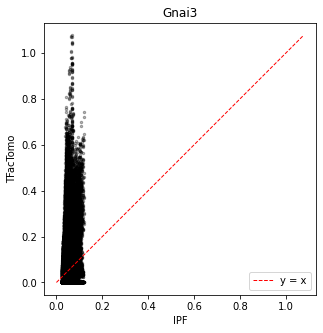

In [43]:
def rowwise_pearson(A, B):
    A = A - A.mean(axis=1, keepdims=True)
    B = B - B.mean(axis=1, keepdims=True)
    num = np.sum(A*B, axis=1)
    den = np.sqrt(np.sum(A*A, axis=1) * np.sum(B*B, axis=1))
    out = np.full(A.shape[0], np.nan, dtype=np.float64)
    ok = den > 0
    out[ok] = num[ok] / den[ok]
    return out

try:
    from scipy.stats import spearmanr
    def rowwise_spearman(A, B):
        out = np.full(A.shape[0], np.nan, dtype=np.float64)
        for i in range(A.shape[0]):
            r, _ = spearmanr(A[i], B[i])
            out[i] = r
        return out
    have_spearman = True
except Exception:
    have_spearman = False
    def rowwise_spearman(A, B):
        return np.full(A.shape[0], np.nan, dtype=np.float64)


In [68]:
pearson = rowwise_pearson(Vi_lin, Vt_lin)
spearman = rowwise_spearman(Vi_lin, Vt_lin)


corr_df = pd.DataFrame({
    "gene": common,
    "pearson": pearson,
    'spearman': spearman})

In [103]:
n

496

In [106]:
s = corr_df['pearson']               
n = s.count()                          # non-NaN count

pct_above_05 = (s > 0.5).sum() / n * 100
pct_above_04 = (s > 0.4).sum() / n * 100
pct_above_02 = (s > 0.2).sum() / n * 100
pct_below_0  = (s <= 0.0).sum() / n * 100
pct_nan      = s.isna().mean() * 100   # optional: how many NaNs overall

print(f'n_nonNaN: {n} / total: {len(corr_df)}')
print(f'> 0.5: {pct_above_05:.2f}%')
print(f'> 0.4: {pct_above_04:.2f}%')
print(f'> 0.2: {pct_above_02:.2f}%')
print(f'≤ 0.0: {pct_below_0:.2f}%')
print(f'NaN: {pct_nan:.2f}%')



pct_below_02 = (s < -0.25).sum() / n * 100
pct_below0  = (s < 0.0).sum() / n * 100

print(f'n_nonNaN: {n} / total: {len(corr_df)}')
print(f'> 0.2: {pct_below_02:.2f}%')
print(f'≤ 0.0: {pct_below0:.2f}%')
print(f'NaN: {pct_nan:.2f}%')

n_nonNaN: 496 / total: 503
> 0.5: 1.61%
> 0.4: 18.95%
> 0.2: 89.92%
≤ 0.0: 4.44%
NaN: 1.39%
n_nonNaN: 496 / total: 503
> 0.2: 1.21%
≤ 0.0: 4.44%
NaN: 1.39%


In [ ]:
corr_df.sort_values(by='pearson', ascending=False)

# count (ignores NaNs)
n_above_05 = (corr_df['pearson'] > 0.5).sum()
n_above_02 = (corr_df['pearson'] > 0.2).sum()
n_above_03 = (corr_df['pearson'] > 0.3).sum()

n_above_04 = (corr_df['pearson'] > 0.4).sum()

n_below_0 = (corr_df['pearson'] <= 0).sum()

print('n_above_05:',n_above_05/len(corr_df))
print('n_above_04:',n_above_04/len(corr_df))
print('n_above_03:',n_above_03/len(corr_df))
print('n_above_02:',n_above_02/len(corr_df))
print('n_below_0:',n_below_0/len(corr_df))


n_above_05: 0.015904572564612324
n_above_04: 0.18687872763419483
n_above_03: 0.6461232604373758
n_above_02: 0.8866799204771372
n_below_0: 0.0437375745526839


503

In [101]:
corr_df.sort_values('pearson', ascending=True).head(30)


,gene,pearson,spearman
159,Sgca,-0.378883,-0.750468
169,Tcea3,-0.357514,-0.407445
368,Fkbp11,-0.342694,-0.568301
498,Pax3,-0.325364,-0.464862
479,Chn2,-0.286428,-0.240707
255,Rec8,-0.255262,-0.735357
156,Meox1,-0.228823,-0.560775
500,Nes,-0.218620,-0.587690
75,Tcf7,-0.214539,-0.584648
13,Igsf5,-0.189145,-0.586162


<ipython-input-85-33f3cec9ef0c>:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


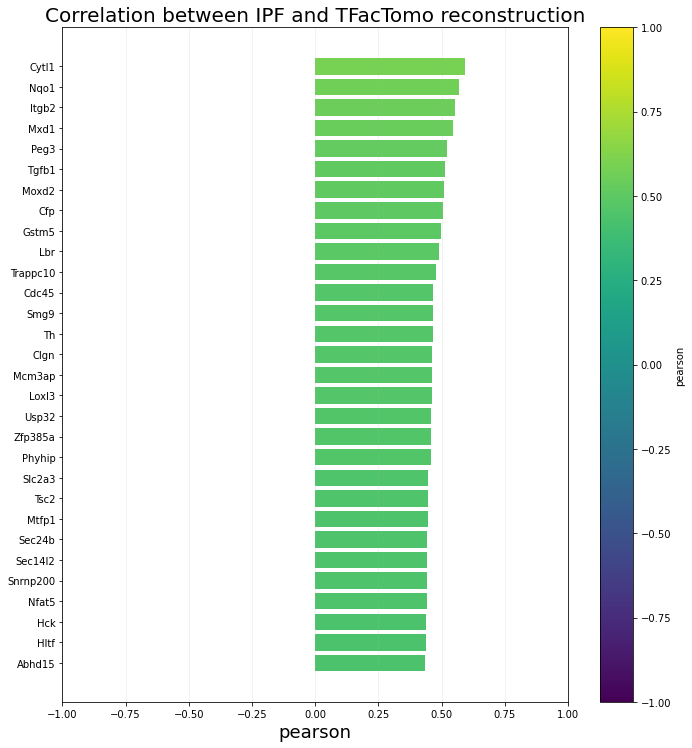

<ipython-input-85-33f3cec9ef0c>:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


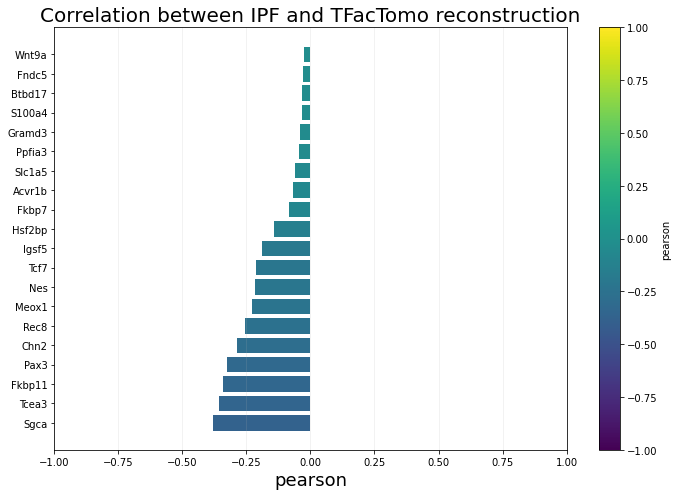

<ipython-input-85-33f3cec9ef0c>:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


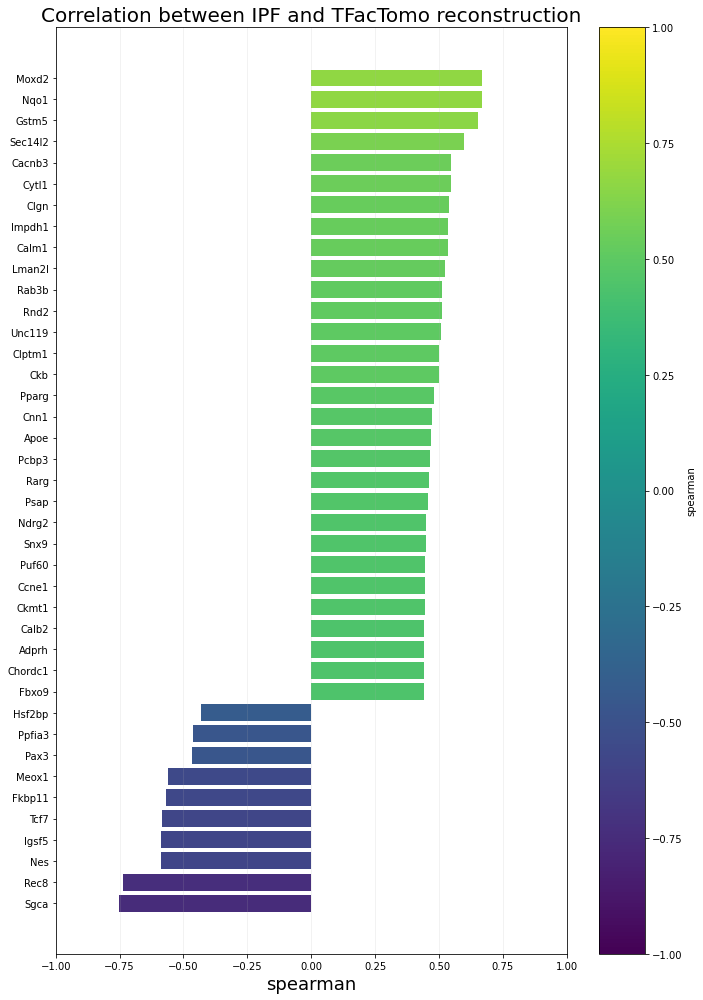

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def corr_barplot(corr_df, metric='pearson', top=30, bottom=0, save=None):

    df = corr_df[['gene', metric]].dropna().sort_values(metric, ascending=False) # drop NaN values

    if bottom > 0:
        plot_df = pd.concat([df.head(top), df.tail(bottom)])
        title ='Correlation between IPF and TFacTomo reconstruction'
    else:
        plot_df = df.head(top)
        title = title ='Correlation between IPF and TFacTomo reconstruction'

    plot_df = plot_df.sort_values(metric, ascending=True)

    plt.figure(figsize=(10, max(4, 0.35*len(plot_df))))


    # color values
    cmap = plt.cm.viridis
    norm = plt.Normalize(-1, 1)  # correlations live in [-1, 1]
    colors = cmap(norm(plot_df[metric].values))


    # barplot
    
    plt.barh(plot_df['gene'], plot_df[metric].values, color=colors)
    plt.xlabel(metric.replace('_', ' '), fontsize=18)
    plt.title(title, fontsize=20)
    plt.xlim(-1, 1)  # keep consistent scale across plots
    plt.grid(axis='x', alpha=0.2)
    plt.tight_layout()

    # colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label(metric.replace('_', ' '))

    if save:
        plt.savefig(save, dpi=200)
    plt.show()

# Examples:
corr_barplot(corr_df, metric='pearson', top=30)                 # top-30, linear space
corr_barplot(corr_df, metric='pearson', top=0, bottom=20)                 # top-30, linear space
corr_barplot(corr_df, metric='spearman', top=30, bottom=10)       # mix of best & worst, log1p space


In [424]:
def scale_ls(Yhat, Y, M):
    x = (Yhat * M).ravel().astype(np.float64)
    y = (Y * M).ravel().astype(np.float64)
    den = np.dot(x, x)
    a = 0.0 if den == 0 else float(np.dot(x, y) / den)
    return Yhat * a, a



In [425]:
M_bool = (mask3d > 0)

In [426]:
T_mayra = tensor_from_Ai(A_mayra, gene_name='Moxd2', mask=M)

In [412]:
np.save( "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/T_mayra_moxd2_tfactomo.npy", T_mayra)

In [394]:
ipf_moxd2 = np.load( "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/testing_results/T_mayra_moxd2_ipf.npy")

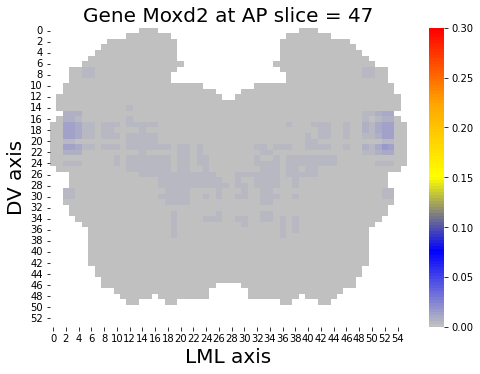

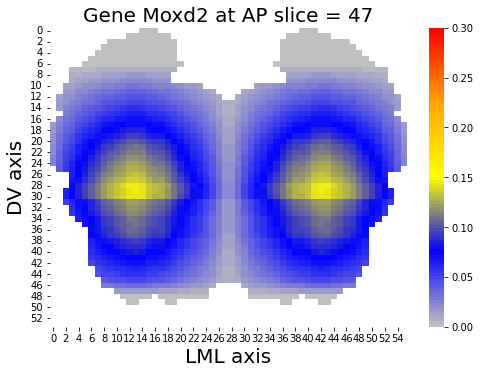

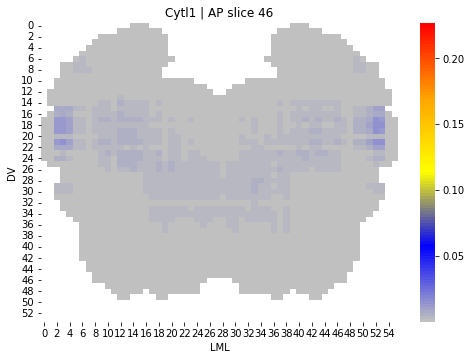

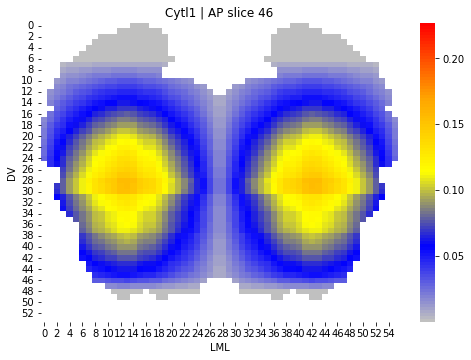

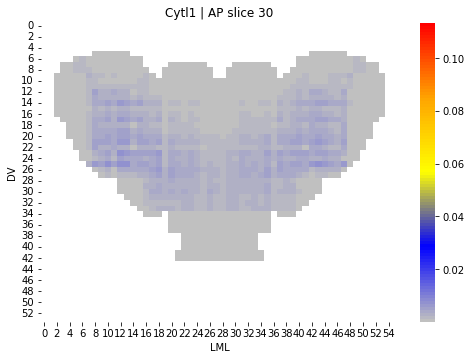

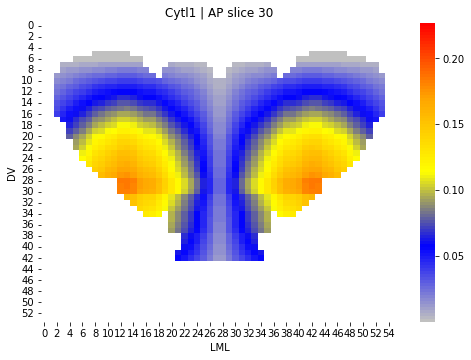

In [541]:
visualize_pa_slice_old(proj_tfactomo_mayra, 47, "Moxd2")
visualize_pa_slice_old(ipf_moxd2, 47, "Moxd2")

visualize_pa_slice(proj_tfactomo_mayra ,mask3d, 46, gene, vmin, vmax/2, use_log10=True)
visualize_pa_slice(ipf_moxd2 ,mask3d, 46, gene, vmin, vmax/2, use_log10=True)

visualize_pa_slice(proj_tfactomo_mayra ,mask3d, 30, gene, vmin, vmax/4, use_log10=True)
visualize_pa_slice(ipf_moxd2 ,mask3d, 30, gene, vmin, vmax/2, use_log10=True)

In [504]:
# visualize

gene = 'Moxd2'
visualize_pa_slice(T=T_mayra, slice_idx=10, gene=f'{gene}',vmin,vmax)
visualize_pa_slice(T=T_mayra, slice_idx=16, gene=f'{gene}',vmin,vmax)
visualize_pa_slice(T=T_mayra, slice_idx=32, gene=f'{gene}',vmin,vmax)
visualize_pa_slice(T=T_mayra, slice_idx=46, gene=f'{gene}',vmin,vmax)
visualize_pa_slice(T=T_mayra, slice_idx=55, gene=f'{gene}',vmin,vmax)

SyntaxError: positional argument follows keyword argument (<ipython-input-504-eb1157e983a2>, line 4)

# Understanding the parameters

In [83]:
print('Parts of A (4 factor matrices:)',len(A_mayra))
print('shape of the gene graphs:', W_g.shape)
print('shape of the x chain graphs:', W_x.shape)
print('shape of the y chain graphs:', W_y.shape)
print('shape of the z chain graphs:', W_z.shape)

Parts of A (4 factor matrices:) 4
shape of the gene graphs: torch.Size([9254, 9254])
shape of the x chain graphs: torch.Size([54, 54])
shape of the y chain graphs: torch.Size([56, 56])
shape of the z chain graphs: torch.Size([60, 60])


In [97]:
import torch

def check_chain_adjacency(W: torch.Tensor):
    n = W.shape[0]
    print("shape:", tuple(W.shape))
    print("symmetric:", bool(torch.allclose(W, W.T)))

    # remove self-loops (your code does this internally anyway)
    W0 = W - torch.diag(torch.diag(W))

    # build ideal open-chain adjacency (unweighted)
    ideal = torch.zeros_like(W)
    i = torch.arange(n-1)
    ideal[i, i+1] = 1
    ideal[i+1, i] = 1

    # if you used weights, allow <= instead of exact equality
    exact_match = bool(torch.equal(W0, ideal))
    leq_mask = bool(torch.all(W0 <= ideal))

    print("exact tri-diagonal (unweighted):", exact_match)
    print("only neighbors connected (allow weights):", leq_mask)

# usage
check_chain_adjacency(W_x)


shape: (54, 54)
symmetric: True
exact tri-diagonal (unweighted): True
only neighbors connected (allow weights): True


In [228]:
def normalize_like_reconstruct(W: torch.Tensor):
    # remove diagonal
    W0 = W - torch.diag(torch.diag(W))
    # symmetric degree-normalization: D^{-1/2} W D^{-1/2}
    d = W0.sum(0)
    d_safe = d.clone()
    nz = d_safe != 0
    d_safe[nz] = d_safe[nz].pow(-0.5)
    Dm = d_safe.unsqueeze(0)         # row vector
    Wn = Dm.T * W0 * Dm
    return W0, Wn

W0_x, Wn_x = normalize_like_reconstruct(W_x)
W0_y, Wn_y = normalize_like_reconstruct(W_y)
W0_z, Wn_z = normalize_like_reconstruct(W_z)
W0_g, Wn_g = normalize_like_reconstruct(W_g)

W_t = torch.as_tensor(W_sub, dtype=torch.float32, device="cpu")  # from numpy -> torch
W0_g_sub, Wn_g_sub = normalize_like_reconstruct(W_t)



Visualizing the graph matrices to understand how the graphs look like

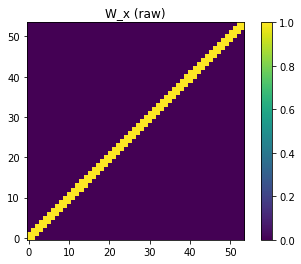

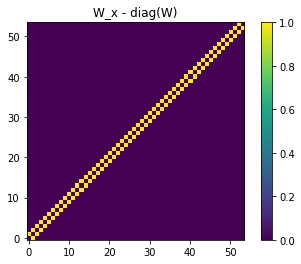

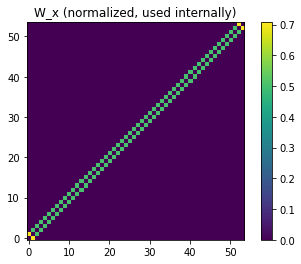

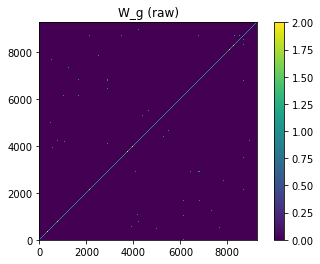

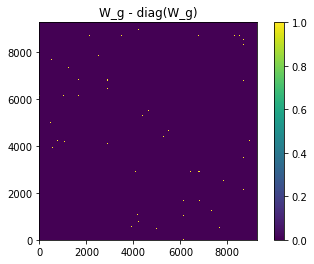

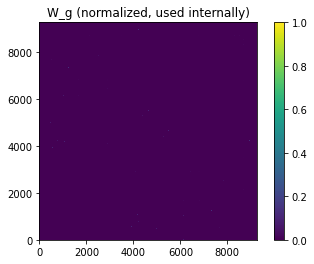

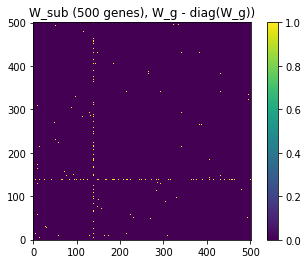

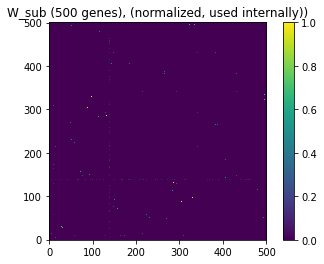

In [229]:
import matplotlib.pyplot as plt

def show_matrix(W, title):
    plt.figure()
    plt.imshow(W.cpu().numpy(), origin="lower", interpolation="none")
    plt.title(title)
    plt.colorbar()
    plt.show()

show_matrix(W_x, "W_x (raw)")
show_matrix(W0_x,  "W_x - diag(W)")
show_matrix(Wn_x,  "W_x (normalized, used internally)")

show_matrix(W_g, "W_g (raw)")
show_matrix(W0_g,  "W_g - diag(W_g)")
show_matrix(Wn_g,  "W_g (normalized, used internally)")

show_matrix(W0_g_sub,  "W_sub (500 genes), W_g - diag(W_g))")
show_matrix(Wn_g_sub,  "W_sub (500 genes), (normalized, used internally))")



In [12]:
import torch, math

def edge_and_rowsums(Wn):
    n = Wn.shape[0]
    # pick a boundary edge and an interior edge
    e_boundary = float(Wn[0,1].item())      # end–interior
    e_interior = float(Wn[1,2].item())      # interior–interior
    # row sums (used to build D_ in your code)
    row_sums = Wn.sum(1)                    # shape [n]
    print("edge(0,1) ~", e_boundary, "   expected ~", 1/math.sqrt(1*2))  # ≈0.7071
    print("edge(1,2) ~", e_interior, "   expected ~", 1/math.sqrt(2*2))  # 0.5
    print("row_sums[:6] =", row_sums[:6].cpu().numpy())
    print("min/mean/max row_sums =", 
          float(row_sums.min()), float(row_sums.mean()), float(row_sums.max()))

# run for x
edge_and_rowsums(Wn_x)


edge(0,1) ~ 0.7071067690849304    expected ~ 0.7071067811865475
edge(1,2) ~ 0.4999999701976776    expected ~ 0.5
row_sums[:6] = [0.70710677 1.2071067  0.99999994 0.99999994 0.99999994 0.99999994]
min/mean/max row_sums = 0.7071067690849304 0.996822714805603 1.2071067094802856


In [13]:
import torch, numpy as np, matplotlib.pyplot as plt

# 1) Basic stats
def graph_stats(W):
    n = W.shape[0]
    W0 = W - torch.diag(torch.diag(W))    # strip diag (what reconstruct() does)
    sym = torch.allclose(W0, W0.T)
    nz = int((W0 != 0).sum().item())
    density = nz / (n*n)
    deg = W0.sum(0)                       # unnormalized degree
    iso = int((deg == 0).sum().item())
    print(f"n={n}, nnz={nz}, density={density:.6f}, symmetric={sym}")
    print(f"isolated={iso} ({iso/n:.2%}), deg min/mean/max={float(deg.min())}/{float(deg.mean()):.2f}/{float(deg.max())}")
    return W0

W0_g = graph_stats(W_g)


n=9254, nnz=113786, density=0.001329, symmetric=True
isolated=15 (0.16%), deg min/mean/max=0.0/12.30/1675.0


In [ ]:
def find_idx(genes, symbol):

    # tolerant match (exact symbol usually works: 'Trp53', 'Mdm2')
    
    hits = np.where(genes == symbol)[0]
    if hits.size: 
        return int(hits[0])

    # fallbacks if casing/aliases differ
    hits = np.where(np.char.upper(genes) == symbol.upper())[0]
    return int(hits[0]) if hits.size else None

i_p53 = find_idx(genes, 'Trp53')
i_mdm2 = find_idx(genes, 'Mdm2')
print("idx Trp53:", i_p53, "idx Mdm2:", i_mdm2)

raw_edge = float(W_g[i_p53, i_mdm2])
print("W_g[Trp53, Mdm2] (raw) =", raw_edge)

idx Trp53: 8425 idx Mdm2: 4495
W_g[Trp53, Mdm2] (raw) = 1.0


In [136]:
X_df

,2,3,4,5,6,7,8,9,10,11,...,25,26,27,28,29,30,31,32,33,34
Gnai3,55.0,92.0,115.0,143.0,142.0,209.0,191.0,233.0,320.0,310.0,...,359.0,315.0,228.0,209.0,132.0,153.0,115.0,66.0,25.0,10.0
Cdc45,1.0,1.0,6.0,2.0,5.0,6.0,5.0,3.0,11.0,13.0,...,7.0,15.0,7.0,4.0,3.0,2.0,2.0,1.0,0.0,1.0
Scml2,3.0,2.0,2.0,8.0,4.0,5.0,5.0,7.0,8.0,17.0,...,18.0,8.0,12.0,11.0,10.0,8.0,4.0,6.0,0.0,0.0
Klf6,73.0,82.0,114.0,138.0,183.0,235.0,244.0,283.0,299.0,268.0,...,332.0,313.0,229.0,229.0,152.0,164.0,107.0,61.0,24.0,6.0
Scmh1,45.0,50.0,97.0,125.0,121.0,178.0,204.0,193.0,240.0,225.0,...,261.0,234.0,202.0,181.0,117.0,100.0,89.0,45.0,14.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mapk13,0.0,0.0,1.0,1.0,1.0,4.0,1.0,10.0,7.0,4.0,...,4.0,4.0,0.0,4.0,1.0,1.0,3.0,0.0,1.0,0.0
Srpk1,35.0,75.0,119.0,125.0,141.0,193.0,219.0,227.0,291.0,304.0,...,269.0,252.0,190.0,154.0,119.0,109.0,83.0,40.0,24.0,15.0
Pax3,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,...,9.0,7.0,4.0,5.0,5.0,0.0,4.0,0.0,1.0,1.0
Lbr,30.0,20.0,63.0,68.0,62.0,115.0,117.0,116.0,158.0,132.0,...,205.0,194.0,153.0,115.0,87.0,90.0,68.0,39.0,25.0,10.0


# Simulated data for TFacTOmo

In [121]:
import numpy as np
import pandas as pd
import torch
import tensorly as tl
tl.set_backend('pytorch')

# load data: tensor of the 500 genes and marginals 

d = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/marginals_500_bundle.npz", allow_pickle=True)
genes_d = d["genes"].astype(str)
X_df = pd.DataFrame(d["X"], index=genes_d, columns=d["rows_all"])
Y_df = pd.DataFrame(d["Y"], index=genes_d, columns=d["cols_all"])
Z_df = pd.DataFrame(d["Z"], index=genes_d, columns=np.arange(d["Z"].shape[1]))

data_frame_tensor = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/tensors_500_bundle.npz", allow_pickle=True)
V4  = data_frame_tensor["V"]
genes_tensor = data_frame_tensor["genes"].astype(str)

genes_ST_500 = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/genes_ST_500_list.npy", allow_pickle=True).astype(str)
genes_run = [g for g in genes_ST_500 if g in X_df.index and g in genes_tensor]

# relabel 
def relabel_cols(df):
    df = df.sort_index(axis=1)
    n = df.shape[1]
    return df.set_axis(range(1, n + 1), axis=1)

X_df_1n = relabel_cols(X_df).loc[genes_run]
Y_df_1n = relabel_cols(Y_df).loc[genes_run]
Z_df_1n = relabel_cols(Z_df).loc[genes_run]

# mask
mask_tensor_ = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/3d_mask.npy")

mask_tensor_sim = (mask_tensor_ > 0).astype(np.float32)

X_dim, Y_dim, Z_dim = mask_tensor_sim.shape
N_genes = len(genes_run)


In [125]:
    W_np = W_g.detach().cpu().numpy() if torch.is_tensor(W_g) else np.asarray(W-g)
    genes_all = np.asarray(genes).astype(str)
    genes_500 = genes_run

    # map full gene -> index
    all_index = {g: i for i, g in enumerate(genes_all)}

    # subset indices (=-1 if missing)
    idx = np.array([all_index.get(g, -1) for g in genes_500], dtype=int)
    present = idx >= 0
    n_total = len(genes_500)
    n_present = int(present.sum())
    n_missing = n_total - n_present
    missing_genes = [g for g, ok in zip(genes_500, present) if not ok]

    genes_out = [g for g, ok in zip(genes_500, present) if ok]
    ip = idx[present]
    W_sub = W_np[np.ix_(ip, ip)].astype(np.float32)

In [126]:
W_t.shape

W_x_sim.shape

NameError: name 'W_t' is not defined

In [127]:
X_df_torch = torch.from_numpy(X_df_1n.to_numpy(dtype=np.float32))   # (N,R)
Y_df_torch = torch.from_numpy(Y_df_1n.to_numpy(dtype=np.float32))   # (N, C)
Z_df_torch = torch.from_numpy(Z_df_1n.to_numpy(dtype=np.float32))   # (N, S)


W_g_sim = torch.as_tensor(W_sub, dtype=torch.float32, device="cpu")  # from numpy -> torch
W_x_sim = torch.eye(X_dim, dtype=torch.float32)   # (R,R)
W_y_sim = torch.eye(Y_dim, dtype=torch.float32)   # (C,C)
W_z_sim = torch.eye(Z_dim, dtype=torch.float32)   # (S,S)



# Your earlier code used 1 - M; keep that if reconstruct expects "1 = missing/forbidden" --> why is this masked changed??
M_tomo = 1.0 - torch.from_numpy(mask_tensor_sim)      

In [128]:
# TFacTomo

A_factors = reconstruct([X_df_torch, Y_df_torch, Z_df_torch], M_tomo, [W_g_sim, W_x_sim, W_y_sim, W_z_sim],
                        500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)

# If reconstruct returns just factor matrices, weights=None:
T_hat = tl.cp_tensor.cp_to_tensor((None, A_factors))  
T_hat_np = T_hat.detach().cpu().numpy().astype(np.float32)

Training epoch: 10, Residual: 0.0282
Training epoch: 20, Residual: 0.0193
Training epoch: 30, Residual: 0.0123
Training epoch: 40, Residual: 0.0092
Training epoch: 50, Residual: 0.0081
Training epoch: 60, Residual: 0.0074
Training epoch: 70, Residual: 0.0062
Training epoch: 80, Residual: 0.0055
Training epoch: 90, Residual: 0.0047
Training epoch: 100, Residual: 0.0040
Training epoch: 110, Residual: 0.0034
Training epoch: 120, Residual: 0.0031
Training epoch: 130, Residual: 0.0028
Training epoch: 140, Residual: 0.0025
Training epoch: 150, Residual: 0.0023
Training epoch: 160, Residual: 0.0022
Training epoch: 170, Residual: 0.0021
Training epoch: 180, Residual: 0.0020
Training epoch: 190, Residual: 0.0019
Training epoch: 200, Residual: 0.0017
Training epoch: 210, Residual: 0.0016
Training epoch: 220, Residual: 0.0015
Training epoch: 230, Residual: 0.0014
Training epoch: 240, Residual: 0.0013
Training epoch: 250, Residual: 0.0012
Training epoch: 260, Residual: 0.0012
Training epoch: 270, 

In [ ]:

idx_V4 = {g:i for i,g in enumerate(genes_tensor)}
V4_sub = V4[[idx_V4[g] for g in genes_run]] 

g = len(genes_run)         # (N,R,C,S)

M = mask_tensor_sim.astype(bool)
mask_flat = M.ravel()
ip = T_hat_np.reshape(g, -1)[:, mask_flat] # reconstruction by marginals
gt = V4_sub.reshape(g, -1)[:, mask_flat] # ground truth

diff = ip - gt
mse  = (diff**2).mean(axis=1)
mae  = np.abs(diff).mean(axis=1)

mse_df = pd.DataFrame({"gene": genes_run, "mse": mse, "mae": mae}).sort_values("mse")
print(mse_df.head())

# ------------ Save results ------------
np.savez_compressed(
    "/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/tfactomo_100_recon.npz",
    T_hat=T_hat_np, genes=np.array(genes_run, dtype="U"),
    axes=np.array(["DV","LML","AP"], dtype="U")
)
mse_df.to_csv("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/tfactomo_vs_orig_mse.csv", index=False)


       gene       mse       mae
372   Cd79a  0.003371  0.004224
138    Sync  0.004087  0.007427
498    Pax3  0.004393  0.006891
64   Abhd15  0.004491  0.007909
254  Tm9sf1  0.004671  0.007923


In [ ]:
# toy example


ipf_flat = np.array([[0.0, 2.0, 1.0, 4.0, 1.0],
                     [1.0, 3.0, 0.0, 2.0, 2.0]])


v4_flat  = np.array([[0.0, 1.0, 1.0, 5.0, 0.0],
                     [1.0, 2.0, 0.0, 2.0, 3.0]])


mask_flat = np.array([False, True, False, True, True])  # keep cols 1,3,4

diff = ipf_flat - v4_flat

# diff =
# [[ 0.,  1., 0., -1.,  1.],
#  [ 0.,  1., 0.,  0., -1.]]

selected = diff[:, mask_flat]    # pick only cols 1,3,4 because here there is "True" → shape (2,3)
# sel =
# [[ 1., -1.,  1.],
#  [ 1.,  0., -1.]]

mse = (selected**2).mean(axis=1) # ^2, mean of voxels


# mse = [ (1+1+1)/3 , (1+0+1)/3 ] = [1.0, 0.666...]

mse

array([1.        , 0.66666667])

In [132]:
# load IPF and TFAC tomo mse plots

mse_tfactomo = pd.read_csv("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/tfactomo_vs_orig_mse.csv")
mse_ipf = pd.read_csv("/Users/kimjob/PhD/PhD/Scripts/Main Project/simulated_data/data/data_simulated/ipf_vs_orig_mse.csv")

Text(0, 0.5, 'MAE TFacTomo')

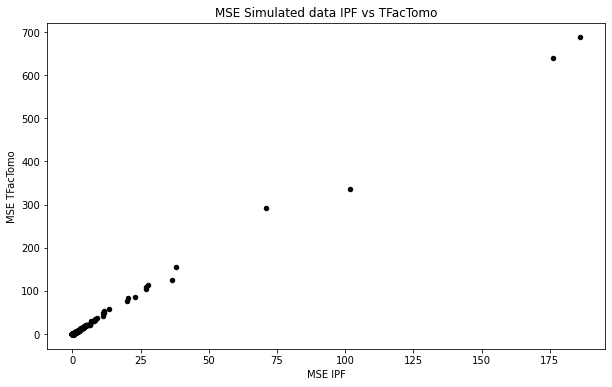

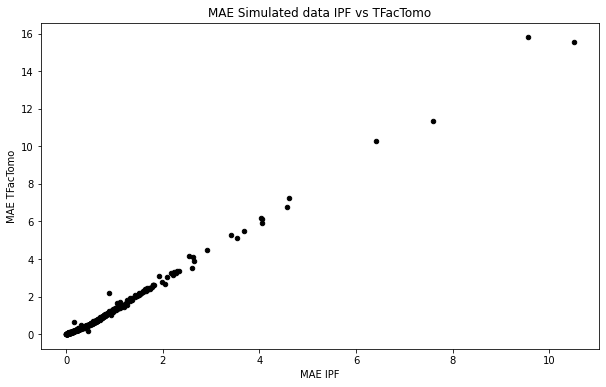

In [133]:
plt.figure(figsize=(10,6))
plt.scatter(x=mse_ipf['mse'], y=mse_tfactomo['mse'], c='k', s=20)
plt.title('MSE Simulated data IPF vs TFacTomo')
plt.xlabel('MSE IPF')
plt.ylabel('MSE TFacTomo')

plt.figure(figsize=(10,6))
plt.scatter(x=mse_ipf['mae'], y=mse_tfactomo['mae'], c='k', s=20)
plt.title('MAE Simulated data IPF vs TFacTomo')
plt.xlabel('MAE IPF')
plt.ylabel('MAE TFacTomo')


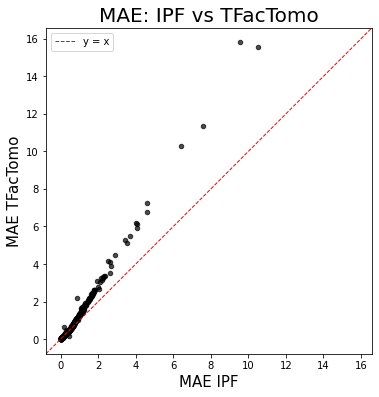

TFacTomo better: 172/501 (34.3%)
IPF better:      329/501 (65.7%)


In [134]:
import numpy as np
import matplotlib.pyplot as plt

# --- MSE ---
x = mse_ipf['mae'].to_numpy()
y = mse_tfactomo['mae'].to_numpy()

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, c='k', s=20, alpha=0.7)

# identity line y = x
lo = min(x.min(), y.min())
hi = max(x.max(), y.max())
pad = 0.05*(hi - lo)
lo, hi = lo - pad, hi + pad

ax.plot([lo, hi], [lo, hi], '--', color='red', lw=1, label='y = x')
ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
ax.set_aspect('equal', adjustable='box')  # make the diagonal 45°

ax.set_title('MAE: IPF vs TFacTomo', fontsize=20)
ax.set_xlabel('MAE IPF', fontsize=15); ax.set_ylabel('MAE TFacTomo', fontsize=15)
ax.legend()
plt.show()

# (optional) how many genes below/above the diagonal
below = np.sum(y < x)   # TFacTomo lower error (better)
above = np.sum(y > x)   # IPF lower error (better)
print(f"TFacTomo better: {below}/{len(x)} ({below/len(x):.1%})")
print(f"IPF better:      {above}/{len(x)} ({above/len(x):.1%})")


In [135]:

def edge_check(W_full, genes_full, W_sub, genes_subset, pairs):
    Wf = W_full.detach().cpu().numpy() if hasattr(W_full, "detach") else np.asarray(W_full)
    Ws = W_sub.detach().cpu().numpy()  if hasattr(W_sub,  "detach") else np.asarray(W_sub)
    gf = np.asarray(genes_full).astype(str)
    gs = np.asarray(genes_subset).astype(str)

    idx_full = {g:i for i,g in enumerate(gf)}
    idx_sub  = {g:i for i,g in enumerate(gs)}

    out = []
    for g1, g2 in pairs:
        i = idx_full.get(g1, -1); j = idx_full.get(g2, -1)
        p = idx_sub.get(g1,  -1); q = idx_sub.get(g2,  -1)
        full = (i >= 0 and j >= 0 and Wf[i, j] != 0)
        sub  = (p >= 0 and q >= 0 and Ws[p, q] != 0)
        out.append((g1, g2, full, sub))
    return out

# example usage
pairs = [("Trp53", "Mdm2"), ("Axin2","Tfe3"), ("Wnt3","Wnt9a")]
for g1,g2,full,sub in edge_check(W_g, genes, W_g_sim, genes_ST_500, pairs):
    print(f"{g1}–{g2}: full={full}, sub={sub}")


Trp53–Mdm2: full=True, sub=False
Axin2–Tfe3: full=False, sub=False
Wnt3–Wnt9a: full=False, sub=False
